# Perplexity ratio score: Kullback–Leibler divergence

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log2
from scipy.stats import fit, exponnorm, gaussian_kde
from IPython.display import Image

import configuration as config

/mnt/arkk/llm_detector/classifier


Plan here is to take our sampling distributions of perplexity ratio scores for human and synthetic text and use them to generate a function that takes a perplexity ratio score and converts it into a Kullback-Leibler score. See the figure below from the [Wikipedia article on KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

In [2]:
Image(url = 'https://raw.githubusercontent.com/gperdrizet/llm_detector/benchmarking/benchmarking/notebooks/images/KL-Gauss-Example.png')

Plan is as follows:
2. Plot and fit the distributions of perplexity ratio scores from human and synthetic text from the training data.
3. Calculate the Kullback-Leibler divergence between the fitted distributions.
4. Use a kernel density estimate of the Kullback-Leibler divergence to get it's probability density function.
5. Use the Kullback-Leibler divergence PDF to calculate a 'Kullback-Leibler score' from the perplexity ratio score for each text fragment in the training and testing datasets.

## TODO
1. Since KL divergence is not symmetrical, maybe we should include two features one for KL divergence between the human and synthetic score distributions in each direction...
2. Maybe try some of the other fits, e.g. gaussian rather than exponential gaussian.

## Load and prepare data

In [3]:
with open(config.FEATURE_ENGINEERING_CLASS_INSTANCE, 'rb') as file:
    data = pickle.load(file)

First we need the distributions of perplexity ratio score values for human and synthetic text.

In [4]:
# Calculate bins for perplexity ratio score from the training data
scores = data.training.all.combined['Perplexity ratio score']
counts, bins = np.histogram(scores, bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and combined synthetic data
human_scores = data.training.all.human['Perplexity ratio score']
synthetic_scores = data.training.all.synthetic_combined['Perplexity ratio score']

human_density, human_bins = np.histogram(human_scores, bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(synthetic_scores, bins = bins, density = True)

Now, fit the individual distributions with an exponential Gaussian:

In [5]:
# Set parameter bounds
bounds = [[0,10],[0.6,1.2],[0,10]]

# Do the fits
human_fit = fit(exponnorm, human_scores, bounds = bounds)
synthetic_fit = fit(exponnorm, synthetic_scores, bounds = bounds)

# Construct functions from each fit
human_exponnorm = exponnorm(human_fit.params.K, human_fit.params.loc, human_fit.params.scale)
synthetic_exponnorm = exponnorm(synthetic_fit.params.K, synthetic_fit.params.loc, synthetic_fit.params.scale)

# Get fitted values for the histogram bin centers
human_fitted_values = human_exponnorm.pdf(bin_centers)
synthetic_fitted_values = synthetic_exponnorm.pdf(bin_centers)

/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)
/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1782: RuntimeWarning: overflow encountered in scalar divide
  invK = 1.0 / K


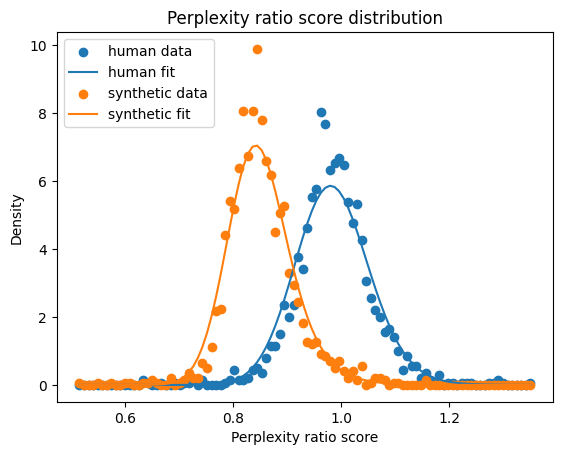

In [6]:
# Plot as scatter
plt.scatter(bin_centers, human_density, label = 'human data')
plt.plot(bin_centers, human_fitted_values, label = 'human fit')
plt.scatter(bin_centers, synthetic_density, label = 'synthetic data')
plt.plot(bin_centers, synthetic_fitted_values, label = 'synthetic fit')

plt.title('Perplexity ratio score distribution')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc = 'upper left')
plt.show()

Ok, looks good to me - let's take a closer look at the fits.

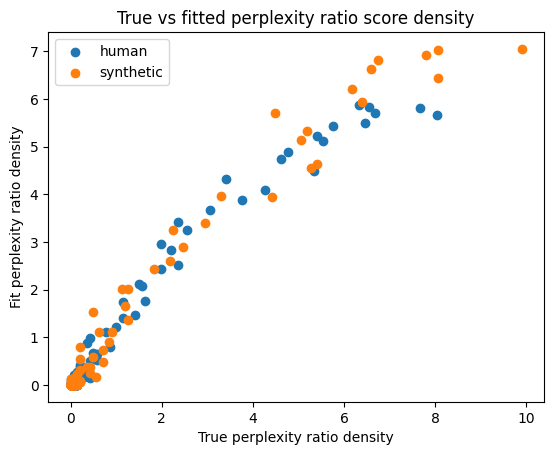

In [7]:
plt.title('True vs fitted perplexity ratio score density')
plt.scatter(human_density, human_fitted_values, label = 'human')
plt.scatter(synthetic_density, synthetic_fitted_values, label = 'synthetic')
plt.legend(loc = 'upper left')
plt.xlabel('True perplexity ratio density')
plt.ylabel('Fit perplexity ratio density')
plt.show()

OK, looks good enough to me - now let's take a look at the Kullback-Leibler divergence of the two fits.

In [8]:
def kl_divergence(p, q):
    '''Takes two lists, calculates KL divergence'''

    return [p[i] * log2(p[i]/q[i]) for i in range(len(p))]

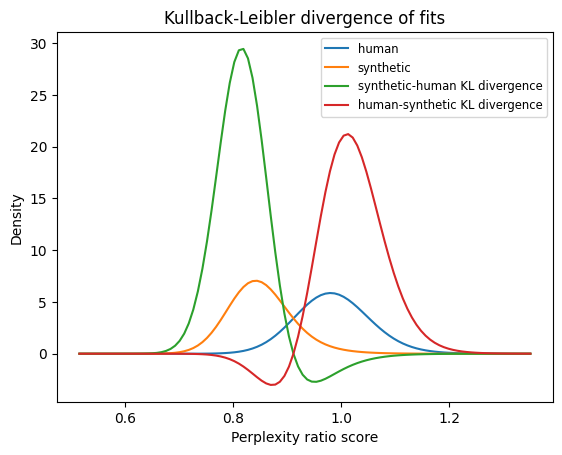

In [9]:
plt.title('Kullback-Leibler divergence of fits')
plt.plot(bin_centers, human_fitted_values, label = 'human')
plt.plot(bin_centers, synthetic_fitted_values, label = 'synthetic')
plt.plot(bin_centers, kl_divergence(synthetic_fitted_values, human_fitted_values), label = 'synthetic-human KL divergence')
plt.plot(bin_centers, kl_divergence(human_fitted_values, synthetic_fitted_values), label = 'human-synthetic KL divergence')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc = 'upper right', fontsize = 'small')
plt.show()

Now we need to use fitted perplexity ratio score distributions to calculate and add the KL score for each text fragment in the dataset. E.g. on the plot above a fragment with a perplexity ratio score of ~0.8 would get a synthetic-human KL divergence score of about 33, etc. To do that we need kernel density estimates for the KL divergence distributions.

In [10]:
# Get a kernel density estimate of the KL divergences so we can use it's
# probability density function to convert perplexity ratio scores
# into KL scores

# Get a list of points covering the range of score values and extend
# the left and right edges a little bit, otherwise the kernel density
# estimate tends to droop at the edges for the range. We will clip
# the padding off later.
x = np.arange(min(scores) - 0.1, max(scores) + 0.1, 0.001).tolist()
print(f'Will calculate {len(x)} fitted values')

# Get fitted values for the points
human_fitted_values = human_exponnorm.pdf(x)
synthetic_fitted_values = synthetic_exponnorm.pdf(x)

# Calculate the KL divergences of the fitted values
synthetic_human_kld = kl_divergence(synthetic_fitted_values, human_fitted_values)
human_synthetic_kld = kl_divergence(human_fitted_values, synthetic_fitted_values)

Will calculate 1043 fitted values


In [11]:
# Convert the kl 'density' values into integer 'count' values
synthetic_human_kld = synthetic_human_kld + abs(min(synthetic_human_kld))
synthetic_human_kld = synthetic_human_kld * 100
synthetic_human_kld_counts = [int(density) for density in synthetic_human_kld]

print(f'Min synthetic-human KLD count value {min(synthetic_human_kld_counts)}')
print(f'Max synthetic-human KLD count value: {max(synthetic_human_kld_counts)}')

human_synthetic_kld = human_synthetic_kld + abs(min(human_synthetic_kld))
human_synthetic_kld = human_synthetic_kld * 100
human_synthetic_kld_counts = [int(density) for density in human_synthetic_kld]

print(f'Min human-synthetic KLD count value {min(human_synthetic_kld_counts)}')
print(f'Max human-synthetic KLD count value: {max(human_synthetic_kld_counts)}')

Min synthetic-human KLD count value 0
Max synthetic-human KLD count value: 3224
Min human-synthetic KLD count value 0
Max human-synthetic KLD count value: 2425


In [12]:
# Now, construct a list where each value of x appears a number of times
# equal to it's kld 'count'
synthetic_human_kld_scores = []
human_synthetic_kld_scores = []

for i in range(len(synthetic_human_kld_counts)):
    synthetic_human_kld_scores.extend([x[i]] * synthetic_human_kld_counts[i])

for i in range(len(human_synthetic_kld_counts)):
    human_synthetic_kld_scores.extend([x[i]] * human_synthetic_kld_counts[i])

In [13]:
# Then, run a KDE on the reconstructed KL scores
synthetic_human_kld_kde = gaussian_kde(synthetic_human_kld_scores)
human_synthetic_kld_kde = gaussian_kde(human_synthetic_kld_scores)

In [14]:
# Finally, use the PDF to get density for x after re-clipping x to the
# range of the original data
clipped_x = []
clipped_synthetic_human_kld = []
clipped_synthetic_human_kld_counts = []
clipped_human_synthetic_kld = []
clipped_human_synthetic_kld_counts = []

for i, j in enumerate(x):
    if j > min(scores) and j < max(scores):

        clipped_x.append(j)

        clipped_synthetic_human_kld.append(synthetic_human_kld[i])
        clipped_human_synthetic_kld.append(human_synthetic_kld[i])

        clipped_synthetic_human_kld_counts.append(synthetic_human_kld_counts[i])
        clipped_human_synthetic_kld_counts.append(human_synthetic_kld_counts[i])

clipped_synthetic_human_kld_kde_values = synthetic_human_kld_kde.pdf(clipped_x)
clipped_human_synthetic_kld_kde_values = human_synthetic_kld_kde.pdf(clipped_x)

Just for good measure, plot each step along the way so we can be sure we did not deform anything.

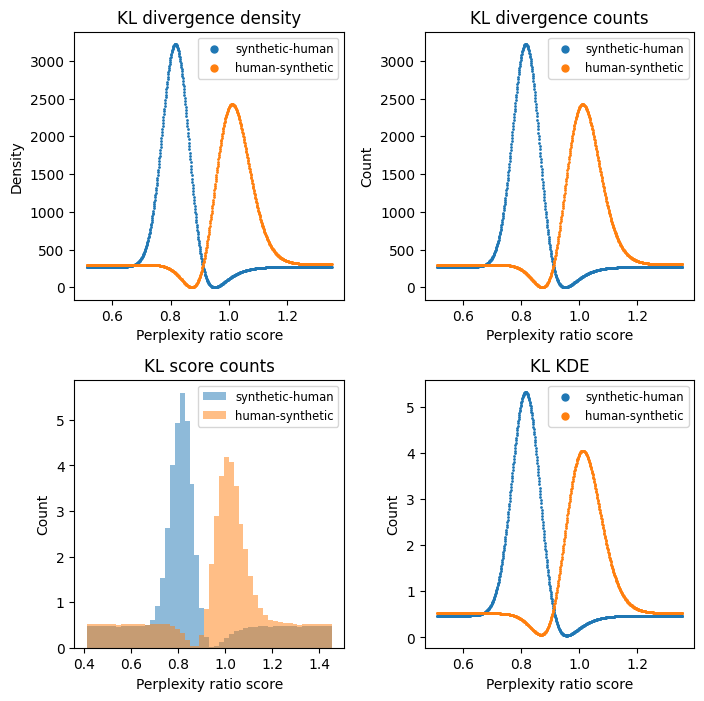

In [15]:
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

axs[0,0].set_title('KL divergence density')
axs[0,0].scatter(clipped_x, clipped_synthetic_human_kld, s = 1, label = 'synthetic-human')
axs[0,0].scatter(clipped_x, clipped_human_synthetic_kld, s = 1, label = 'human-synthetic')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Density')
axs[0,0].legend(loc = 'upper right', fontsize = 'small', markerscale = 5)

axs[0,1].set_title('KL divergence counts')
axs[0,1].scatter(clipped_x, clipped_synthetic_human_kld_counts, s = 1, label = 'synthetic-human')
axs[0,1].scatter(clipped_x, clipped_human_synthetic_kld_counts, s = 1, label = 'human-synthetic')
axs[0,1].set_xlabel('Perplexity ratio score')
axs[0,1].set_ylabel('Count')
axs[0,1].legend(loc = 'upper right', fontsize = 'small', markerscale = 5)

axs[1,0].set_title('KL score counts')
axs[1,0].hist(synthetic_human_kld_scores, bins = 50, density = True, alpha = 0.5, label = 'synthetic-human')
axs[1,0].hist(human_synthetic_kld_scores, bins = 50, density = True, alpha = 0.5, label = 'human-synthetic')
axs[1,0].set_xlabel('Perplexity ratio score')
axs[1,0].set_ylabel('Count')
axs[1,0].legend(loc = 'upper right', fontsize = 'small')

axs[1,1].set_title('KL KDE')
axs[1,1].scatter(clipped_x, clipped_synthetic_human_kld_kde_values, s = 1, label = 'synthetic-human')
axs[1,1].scatter(clipped_x, clipped_human_synthetic_kld_kde_values, s = 1, label = 'human-synthetic')
axs[1,1].set_xlabel('Perplexity ratio score')
axs[1,1].set_ylabel('Count')
axs[1,1].legend(loc = 'upper right', fontsize = 'small', markerscale = 5)

plt.show()

OK, cool. Looks good. Now we can run the perplexity ratio score column from the complete dataset through the Kullback-Leibler divergence distribution's kernel density estimate probability density function to get 'Kullback-Leibler scores' and add them to the dataframe.

In [16]:
# Get the KLD scores
synthetic_human_kld_scores = synthetic_human_kld_kde.pdf(data.all.combined['Perplexity ratio score'])
human_synthetic_kld_scores = human_synthetic_kld_kde.pdf(data.all.combined['Perplexity ratio score'])

# Add the scores to the dataframe
data.all.combined['Synthetic-human perplexity ratio Kullback-Leibler score'] = synthetic_human_kld_scores
data.all.combined['Human-synthetic perplexity ratio Kullback-Leibler score'] = human_synthetic_kld_scores


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4201 entries, 0 to 4200
Data columns (total 16 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Source record num                                        4201 non-null   int64  
 1   Fragment length (words)                                  4201 non-null   int64  
 2   Fragment length (tokens)                                 4201 non-null   int64  
 3   Dataset                                                  4201 non-null   object 
 4   Source                                                   4201 non-null   object 
 5   Generator                                                4201 non-null   object 
 6   String                                                   4201 non-null   object 
 7   Perplexity                                               4201 non-null   float64
 8   Cross-perplexity            

In [19]:
# Update the rest of the data in the class instance so the new columns propagate
data.update_data(data.all.combined)

# Take a look one of the other datasets in the feature engineering class instance
# to be sure that the new columns propagated correctly
data.training.all.combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3361 entries, 0 to 3360
Data columns (total 16 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Source record num                                        3361 non-null   int64  
 1   Fragment length (words)                                  3361 non-null   int64  
 2   Fragment length (tokens)                                 3361 non-null   int64  
 3   Dataset                                                  3361 non-null   object 
 4   Source                                                   3361 non-null   object 
 5   Generator                                                3361 non-null   object 
 6   String                                                   3361 non-null   object 
 7   Perplexity                                               3361 non-null   float64
 8   Cross-perplexity            

Re-plot just to be sure we got the result we expected

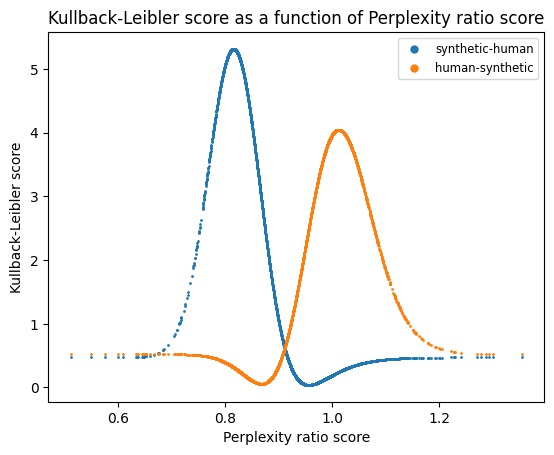

In [20]:
plt.title('Kullback-Leibler score as a function of Perplexity ratio score')
plt.scatter(data.all.combined['Perplexity ratio score'], data.all.combined['Synthetic-human perplexity ratio Kullback-Leibler score'], s = 1, label = 'synthetic-human')
plt.scatter(data.all.combined['Perplexity ratio score'], data.all.combined['Human-synthetic perplexity ratio Kullback-Leibler score'], s = 1, label = 'human-synthetic')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Kullback-Leibler score')
plt.legend(loc = 'upper right', fontsize = 'small', markerscale = 5)
plt.show()

Nailed it! Save for the next step.

In [21]:
# Persist the feature engineering class instance so we can
# use it in other notebooks

with open(config.FEATURE_ENGINEERING_CLASS_INSTANCE, 'wb') as file:
    pickle.dump(data, file)